# Assignment 2
**Sunil Simha**

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.constants import h, c

from importlib import reload
from instrumentsim.filters import transcurve as tc
from instrumentsim import ccd

from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup, IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [117]:
plt.rcParams['font.size'] = 16

## Part 1:  Predicting observed counts from an astrophysical source
### 1. Synthetic photometry

Measuring the magnitudes of HG205905 with different filters. I'm using the Transmission_curve class I've defined in the repository for this purpose.

In [4]:
# First read in the spectrum
spectab = Table.read("../instrumentsim/data/hd205905_stis_005.fits",hdu=1)
spectab

WAVELENGTH,FLUX,STATERROR,SYSERROR,FWHM,DATAQUAL,TOTEXP
ANGSTROMS,FLAM,FLAM,FLAM,ANGSTROMS,NONE,SEC
float64,float32,float32,float32,float32,int16,float32
1711,3.4566e-14,1.1034e-14,3.4566e-16,2.7,1,7.5e+02
1712,1.0601e-14,1.1230e-14,1.0601e-16,2.7,1,7.5e+02
1714,1.0811e-14,1.0583e-14,1.0811e-16,2.7,1,7.5e+02
1715,1.1485e-14,1.0360e-14,1.1485e-16,2.7,1,7.5e+02
1716,7.7030e-15,1.0077e-14,7.7030e-17,2.7,1,7.5e+02
1718,-8.5711e-15,9.7486e-15,8.5711e-17,2.7,1,7.5e+02
1719,-2.0622e-15,9.6630e-15,2.0622e-17,2.7,1,7.5e+02
1721,1.0589e-14,9.6909e-15,1.0589e-16,2.7,1,7.5e+02


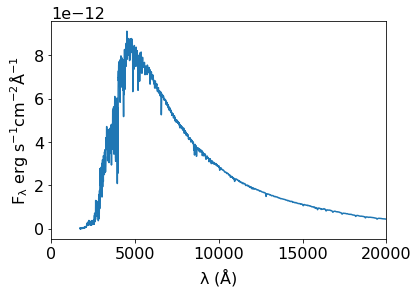

In [23]:
# Visualize the spectrum
plt.plot(spectab['WAVELENGTH'], spectab['FLUX'])
plt.xlabel(r"$\rm \lambda~(\AA)$")
plt.ylabel(r"$\rm F_\lambda~erg~s^{-1}cm^{-2}\AA^{-1}$")
plt.xlim(0, 20000)
plt.show()

In [27]:
# Instantiate a Transmission_curve for Bessel B
besselB_dat = Table.read("../instrumentsim/data/bessell_B.dat", format="ascii",names=['wave','t'])
besselB = tc.Transmission_curve(besselB_dat['wave'].data*u.AA, besselB_dat['t'])

In [28]:
# Compute magnitude
fluxunits = u.erg*u.s**-1*u.cm**-2*u.AA**-1

besselB.synthmag(spectab['FLUX'].data*fluxunits, spectab['WAVELENGTH'].data*u.AA, vega=True)

7.318762952665714

In [29]:
# Repeat for other curves
# Bessel V
besselV_dat = Table.read("../instrumentsim/data/bessell_V.dat", format="ascii",names=['wave','t'])
besselV = tc.Transmission_curve(besselV_dat['wave'].data*u.AA, besselV_dat['t'])

besselV.synthmag(spectab['FLUX'].data*fluxunits, spectab['WAVELENGTH'].data*u.AA, vega=True)

6.705425895015934

In [30]:
# Bessel I
besselI_dat = Table.read("../instrumentsim/data/bessell_I.dat", format="ascii",names=['wave','t'])
besselI = tc.Transmission_curve(besselI_dat['wave'].data*u.AA, besselI_dat['t'])

besselI.synthmag(spectab['FLUX'].data*fluxunits, spectab['WAVELENGTH'].data*u.AA, vega=True)

6.0222572656045035

In [31]:
# Sloan g
sloang_dat = Table.read("../instrumentsim/data/g.dat", format="ascii",names=['wave','t1','t2','t3','t4'], comment="#")
sloang = tc.Transmission_curve(sloang_dat['wave'].data*u.AA, sloang_dat['t1']) # t1 corresponds to point source

sloang.synthmag(spectab['FLUX'].data*fluxunits, spectab['WAVELENGTH'].data*u.AA, vega=False)

7.001331259277503

In [32]:
# NIRI J
niriJ_dat = Table.read("../instrumentsim/data/niri-J-G0202.dat", format="ascii", data_start=3,names=['wave','t'])
niriJ = tc.Transmission_curve(niriJ_dat['wave'].data*u.nm, niriJ_dat['t']/100)

niriJ.synthmag(spectab['FLUX'].data*fluxunits, spectab['WAVELENGTH'].data*u.AA, vega=False)

6.522946517344841

### 2. Instrument throughput and atmospheric transmittance
Computing photon counts from stars of different V band magnituderequires creation of an effective transmission curve including atmospheric transmission and instrument throughput.

In [88]:
# Create an effective V band transmission curve including reflective losses, QE and atmospheric transmission.

# Read in instrument characteristics
Al_refl_dat = Table.read("../instrumentsim/data/aluminum.dat", format="ascii", names=['wave', 'refl'])
QE_dat = Table.read("../instrumentsim/data/e2vhirhomulti.txt", format="ascii", comment="#", names=['wave','qe'])

# Read in atmospheric transmission
atm_opt_dat = Table.read("../instrumentsim/data/optical_extinction.dat", format="ascii")

# Interpolate everything
Al_refl = interp1d(Al_refl_dat['wave']*1e4, Al_refl_dat['refl']/100, kind="cubic", bounds_error=False, fill_value=0) # (reflectance vs lambda in angstroms)
QE = interp1d(QE_dat['wave']*1e4, QE_dat['qe']/100, kind="cubic", bounds_error=False, fill_value=0) # (QE vs lambda in angstroms)
atm_opt = interp1d(atm_opt_dat['wavelength'], atm_opt_dat['xatm'], kind="cubic", bounds_error=False, fill_value=0)

# Create an effective transmission curve for Bessel V
# Atmospheric transmission + Four reflective surfaces + QE + Filter transmission
wave = besselV_dat['wave']
V_eff = tc.Transmission_curve(wave*u.AA, Al_refl(wave)**4*QE(wave)*atm_opt(wave)*besselV_dat['t'])

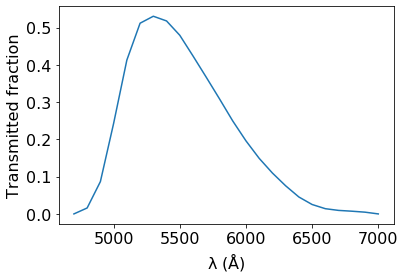

In [69]:
# Visualize
plt.plot(V_eff.wave, V_eff.trans)
plt.xlabel(r"$\rm \lambda~(\AA)$")
plt.ylabel("Transmitted fraction")
plt.show()

In [62]:
# Compute total counts from 60 s exposures of stars of different magnitudes.
t_exp = 60*u.s
area = np.pi*(200*u.cm)**2

# mag 10
V_eff.magtocounts(10, vega=True)*t_exp*area

<Quantity 3.57471061e+08>

In [64]:
# mag 18
V_eff.magtocounts(18, vega=True)*t_exp*area

<Quantity 225548.99141577>

In [65]:
# mag 24
V_eff.magtocounts(24, vega=True)*t_exp*area

<Quantity 897.92670794>

### 3. Sky counts per pixel

In [77]:
# Read in sky emission data
sky_dat = Table.read("../instrumentsim/data/skybg_50_10.dat", format="ascii", comment="#", names=["wave", 'ilam'])
# convert photon counts to to erg/s/cm^2/AA/arcsec^2
sky_dat['wave'] = sky_dat['wave']*10*u.AA # Convert to AA
sky_dat['ilam'] = sky_dat['ilam']*(h*c/sky_dat['wave']).to('erg').value/100**2/10*fluxunits/u.arcsec**2

In [78]:
# Compute flux per pixel
platescale = 16.5*0.015*u.arcsec # arcsec/pixel
sky_dat['flam'] = sky_dat['ilam']*platescale**2
sky_dat

wave,ilam,flam
Angstrom,erg / (Angstrom arcsec2 cm2 s),erg / (Angstrom cm2 s)
float64,float64,float64
3200.0,0.0,0.0
3499.9,0.0,0.0
3501.7000000000003,3.6907264319076225e-17,2.260800609945413e-18
3504.3,3.68685439457142e-17,2.2584287450746553e-18
3507.0,3.682316657349638e-17,2.2556490974177375e-18
3509.6,3.678456697518488e-17,2.2532846307736685e-18
3512.3,3.673932263200591e-17,2.2505131319768122e-18
3514.9,3.670084325677868e-17,2.2481560297480487e-18


In [81]:
# Create effective B and I bands
wave = besselB_dat['wave']
B_eff = tc.Transmission_curve(wave*u.AA, Al_refl(wave)**4*QE(wave)*atm_opt(wave)*besselB_dat['t'])

wave = besselI_dat['wave']
I_eff = tc.Transmission_curve(wave*u.AA, Al_refl(wave)**4*QE(wave)*atm_opt(wave)*besselI_dat['t'])

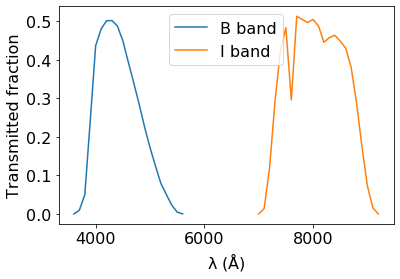

In [82]:
plt.plot(B_eff.wave, B_eff.trans, label="B band")
plt.plot(I_eff.wave, I_eff.trans, label="I band")
plt.legend()
plt.xlabel(r"$\rm \lambda~(\AA)$")
plt.ylabel("Transmitted fraction")
plt.show()

In [85]:
# Measure counts
# B band
bcounts = B_eff.synthcounts(sky_dat['flam'], sky_dat['wave'])*t_exp*area
bcounts

<Quantity 1305.10251363>

In [90]:
# I band
icounts = I_eff.synthcounts(sky_dat['flam'], sky_dat['wave'])*t_exp*area
icounts

<Quantity 3585.60135402>

## Part 2: PSFs and photometry
### 3. Simulating a star
The star is given to be 20th magnitude in V band. The instrument has a gaussian PSF. Two images need to be produced simulating different PSF FWHMs. I shall assume the same CCD characteristics as in Assignment 1:

platescale: 0.2475''/pixel

read_noise: 3 e-

dark_current: 3 e-/pixel/hr

saturation_counts = 200,000

Gain: 1 DN/ e-

I shall also assume a 600 s exposure and the collecting area equivalent to a circle of 200 cm diameter.

In [97]:
# First compute the count rate from the star in the V band
t_exp = 600*u.s
area = np.pi*(200*u.cm)**2
star_counts = V_eff.magtocounts(20, vega=True)*area
star_counts

<Quantity 595.78510177 1 / s>

In [126]:
# Compute sky background counts in V band
sky_bkg = V_eff.synthcounts(sky_dat['flam'], sky_dat['wave'])*area/platescale**2
sky_bkg

<Quantity 380.5433322 1 / (arcsec2 s)>

In [132]:
img1, bkg1 = ccd.mock_img(star_counts.value, platescale.value, t_exp.value,
                          fwhm = 1.4, bkg_flux=sky_bkg.value,
                          gaussianPSF=True)
img2, bkg2 = ccd.mock_img(star_counts.value, platescale.value, t_exp.value,
                          fwhm = 0.7, bkg_flux=sky_bkg.value,
                          gaussianPSF=True)

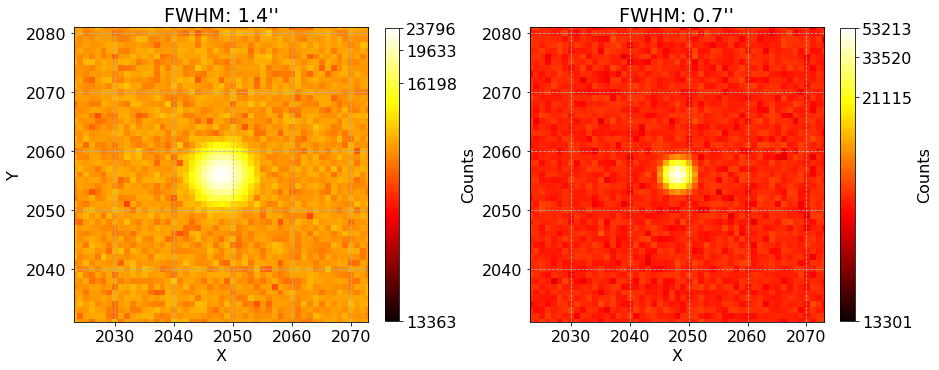

In [173]:
titles = ["FWHM: 1.4''", "FWHM: 0.7''"]
imglist = [img1, img2]

# begin plotting
fig, axs = plt.subplots(1,2,figsize=(14, 6))
fig.subplots_adjust(wspace=0.4)
axs[0].set_ylabel("Y")

for img, ax, title in zip(imglist, axs, titles):
    # get colorbar level ticks
    cb_low, cb_high = np.min(img), np.max(img)
    cbticks = np.logspace(np.log2(cb_low), np.log2(cb_high), 4, base = 2)

    # draw the image
    ccd.draw_img(ax,fig, img, cblabel = "Counts", cbticks=cbticks, title=title, range=25)

    # annotate pixels
    # Star
    #ax.annotate(str(cb_high), (img.shape[0]/2, img.shape[1]/2), (2060, 2080),
    #            arrowprops=dict(arrowstyle="->", connectionstyle="angle3", lw=2),
    #            path_effects=[PathEffects.withStroke(linewidth=3,foreground="w")])
    # Random background pixel
    #ax.annotate(str(img[2060, 2020]), (2060, 2020), (2020, 2040),
    #            arrowprops=dict(arrowstyle="->", connectionstyle="angle3", lw=2),
    #            path_effects=[PathEffects.withStroke(linewidth=3,foreground="w")])

    # Label
    ax.set_xlabel("X")
# And show
plt.show()

### 4. Aperture photometry
I'll be using apertures of radius $2''$ and $1''$ respectively to compute the star flux and an annulus of inner and outer radii 15 and 20 pixels respectively for the background flux measurement.

In [187]:
# First image
star_x, star_y = img1.shape[0]/2, img1.shape[1]/2 # Star centroid
rad1 = 2/platescale.value # Radius of the aperture: 2sigma
photom_1 = ccd.circ_aper_photom(img1, star_x, star_y, rad1)
photom_1

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,object_flux,bkg_flux,SNR
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,2048.0,2056.0,3227569.747964016,7693745.851637446,356727.2129177572,2870842.535046259,198.5630442965291


In [189]:
# Second image
rad2 = 1/platescale.value # Radius of aperture: 2sigma
photom_2 = ccd.circ_aper_photom(img2, star_x, star_y, rad2)
photom_2

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,object_flux,bkg_flux,SNR
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,2048.0,2056.0,1071757.9770058934,7691929.363911593,354216.7941960604,717541.182809833,342.15334164131684


Having a smaller PSF gives a higher SNR and this is intuitive because while the sky background level remains unchanged, the source photons are concentrated in fewer pixels. Thus, with the same instrument and exposure time, choosing a location with better seeing ensures better images.

### 5. PSF photometry
Using `photutils`, one can model the PSF and perform much more accurate photometry for point sources. As the model PSF is gaussian, we can directly use one of the in-built functions, `IntegratedGaussianPRF`, as the PSF model instead of building it from data. One can also automate the process of PSF photometry by using a star-finder algorithm (instead of manually feeding the centroid values) and a grouping algorithm ot speed up fitting. Naturally, none of this is necessary for our test image but this is a scaled solution.

In [192]:
# Define FWHM. This is found manually using imexam or some such tool
fwhm = 2/platescale.value # Guessing for now.

# Choose a background estimator
bkgrms = MADStdBackgroundRMS()

# Estimate background std.dev
std = bkgrms(img1)

# Find sources above a threshold with the known FWHM
# Setting the threshold to 20 times the sky RMS because
# the source is known. For a real image, usuall ~3sigma is chosen.
iraffind = IRAFStarFinder(threshold=20*std,
                          fwhm=fwhm)

# Choose a grouping algorithm (when there are multiple sources in the field)
daogroup = DAOGroup(2.0*fwhm)

# Backgroung model for the PSF fitting
mmm_bkg = MMMBackground()

# Optimization algorithm for fitting
fitter = LevMarLSQFitter()

# PSF model
psf_model = IntegratedGaussianPRF(sigma=rad1/2)
psf_model.sigma.fixed = False # Let the fitter find the exact sigma

# Set up PSF photometry tool
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(51,51))

# Perform fit
result_tab = photometry(image=img1)

# Compute residual image
residual_image = photometry.get_residual_image()

In [193]:
# Look at results
result_tab

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,sigma_0,sigma_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,sigma_unc,iter_detected
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int32
2048.024914599773,2048.0098464023927,2056.0118966003083,2056.0052295758965,358962.4836075398,360792.742960714,4.040404040404041,2.4009260685680247,1,1,1430.318365632633,0.009605619452153158,0.009605769735793964,0.006838229996717922,1


Great, our star has been found! The table columns with `fit` in their names correspond to the parameters obtained by the fitter. The source counts from fitting correspond to `flux_fit`. Clearly, the fit has managed to capture more counts (\~360,000) than the aperture photometry (\~300,000). The uncertainty in the flux comes from the fitting process and therefore the signal to noise here is given by:

In [194]:
snr = result_tab['flux_fit']/result_tab['flux_unc']
snr[0]

252.24645899106144

This is \~25% higher than the aperture photometry SNR. The extra counts certainly help.